In [1]:
import glob, os, json, re, unicodedata
from bs4 import BeautifulSoup


load_verbose = 0
loaded_labels = []
loaded_text = []
labels = {"Barack Obama": 0,
          "Donald J. Trump": 1,
          "Dwight D. Eisenhower": 2,
          "Franklin D. Roosevelt": 3,
          "George Bush": 4,
          "George W. Bush": 5,
          "Gerald R. Ford": 6,
          "Harry S. Truman": 7,
          "Herbert Hoover": 8,
          "Jimmy Carter": 9,
          "John F. Kennedy": 10,
          "Lyndon B. Johnson": 11,
          "Richard Nixon": 12,
          "Ronald Reagan": 13,
          "William J. Clinton": 14}

# load raw text files straight in, no parsing
directory = "../data/processed/"
file_to_label = {"Obama": "Barack Obama", "Trump": "Donald J. Trump"}
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
    raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
    loaded_text = loaded_text + [raw] 
        
# load JSON text files; parsing into raw text
directory = "../data/unprocessed/"
for filename in glob.glob(os.path.join(directory, '*.json')):
        json_data=open(filename)
        data = json.load(json_data)
        json_data.close()
        for data2 in data["speeches"]:
            if ('News Conference With' not in data2['name']):
                # data2['text'] has a lot of htmtl tags in there. We still need to parse it            
                raw = BeautifulSoup(data2['text'], "html.parser").get_text(" ")
                raw = unicodedata.normalize('NFKD', raw).encode('ascii','ignore')
                # Remove []
                raw = re.sub(' \[.*?\]',' ', raw, flags=re.DOTALL)
                # Remove ()
                raw = re.sub(' \(.*?\)',' ', raw, flags=re.DOTALL)
                # Removing the questions
                raw = re.sub('[A-Z,\s,\.]Q\..*? The President\.','\.',raw, flags=re.DOTALL)
                raw = re.sub('^[A-Z,\s]*THE PRESIDENT\.','',raw, flags=re.DOTALL)
                raw = re.sub('[A-Z,\s,\.]Q\..*?THE PRESIDENT\.','\.',raw, flags=re.DOTALL)
                
                # capture speaker (i.e., label)
                speaker = data2['speaker']
                
                # push speaker and text
                if (load_verbose == 1):
                    print "Loading: ", data2['speaker'], "(", labels[speaker], "), ", data2['name']
                loaded_labels = loaded_labels + [labels[speaker]] 
                loaded_text = loaded_text + [raw]

# input_text = loaded_text
# input_labels = loaded_labels

print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."

Loaded 1750 speeches for 15 presidents.


In [2]:
import numpy as np

# summary stats & chop up into smaller
#print "Loaded", len(input_text), "speeches for", len(set(input_labels)), "presidents."

print "\nHow many speeches per president?"
speech_freq = np.bincount(loaded_labels)
for key, value in sorted(labels.iteritems()):
    print str(value).ljust(2), ":", key.ljust(20), "\t", speech_freq[value]
  
print "\nApproximately many words of text per president?"
for key, value in sorted(labels.iteritems()):
    label_set = [cnt for cnt, idx in enumerate(loaded_labels) if idx == value]
    label_speeches = [loaded_text[i] for i in label_set]
    print str(value).ljust(2), ":", key.ljust(20), "\t", sum(len(speech.split()) for speech in label_speeches)

print "\nApproximately how many average words per speech per president?"
for key, value in sorted(labels.iteritems()):
    label_set = [cnt for cnt, idx in enumerate(loaded_labels) if idx == value]
    label_speeches = [loaded_text[i] for i in label_set]
    print str(value).ljust(2), ":", key.ljust(20), "\t", (sum(len(speech.split()) for speech in label_speeches)) / speech_freq[value]



How many speeches per president?
0  : Barack Obama         	152
1  : Donald J. Trump      	19
2  : Dwight D. Eisenhower 	192
3  : Franklin D. Roosevelt 	223
4  : George Bush          	97
5  : George W. Bush       	54
6  : Gerald R. Ford       	40
7  : Harry S. Truman      	301
8  : Herbert Hoover       	267
9  : Jimmy Carter         	59
10 : John F. Kennedy      	63
11 : Lyndon B. Johnson    	134
12 : Richard Nixon        	39
13 : Ronald Reagan        	46
14 : William J. Clinton   	64

Approximately many words of text per president?
0  : Barack Obama         	899079
1  : Donald J. Trump      	87764
2  : Dwight D. Eisenhower 	579577
3  : Franklin D. Roosevelt 	392144
4  : George Bush          	354916
5  : George W. Bush       	322439
6  : Gerald R. Ford       	127862
7  : Harry S. Truman      	397252
8  : Herbert Hoover       	164674
9  : Jimmy Carter         	226731
10 : John F. Kennedy      	243153
11 : Lyndon B. Johnson    	425941
12 : Richard Nixon        	178999
13 : Ronald Reagan

In [3]:
import nltk.data
from scipy import stats

# parse speeches into sentences and see what we have
input_text = []
input_labels = []

sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
for idx in range(0,len(loaded_text)):
    speech = loaded_text[idx]
    label = loaded_labels[idx]
    parsed_sentences = sent_detector.tokenize(speech.strip())
    input_text = input_text + parsed_sentences
    input_labels = input_labels + ([label]*len(parsed_sentences))

print "Parsed ", len(input_text), "sentences, applying", len(input_labels), "labels."

print "\nHow many sentences of text per president?"
sentence_label_count = np.bincount(input_labels)
for key, value in sorted(labels.iteritems()):
    print str(value).ljust(2), ":", key.ljust(20), "\t", sentence_label_count[value]

print "\nSummary stats of sentence counts"
print stats.describe(sentence_label_count)

max_sentence_len_char = len(max(input_text, key=len))
max_sentence_len_word = len(max(input_text, key=len).split())

print "\nMaximum sentence length (characters):", max_sentence_len_char
print "Maximum sentence length (words):", max_sentence_len_word
print "\nLongest sentence:", max(input_text, key=len)

Parsed  303108 sentences, applying 303108 labels.

How many sentences of text per president?
0  : Barack Obama         	46115
1  : Donald J. Trump      	7436
2  : Dwight D. Eisenhower 	30381
3  : Franklin D. Roosevelt 	26401
4  : George Bush          	24820
5  : George W. Bush       	22448
6  : Gerald R. Ford       	7455
7  : Harry S. Truman      	43005
8  : Herbert Hoover       	7595
9  : Jimmy Carter         	12174
10 : John F. Kennedy      	12436
11 : Lyndon B. Johnson    	25931
12 : Richard Nixon        	8379
13 : Ronald Reagan        	10544
14 : William J. Clinton   	17988

Summary stats of sentence counts
DescribeResult(nobs=15, minmax=(7436, 46115), mean=20207.200000000001, variance=159986167.02857143, skewness=0.7711964435384968, kurtosis=-0.4618739369874838)

Maximum sentence length (characters): 1364
Maximum sentence length (words): 245

Longest sentence: And throughout this process, based on hours of meetingsif you tallied it up, days or weeks of meetings where we went throu

In [59]:
# adjust sentence volumes 
from operator import itemgetter 

# approach here is too simplistic but it suffices for now:
#   If <= threshold, take all; else just pick first threshold # of sentences sentences

sentence_max_threshold = 7500

trimmed_text = []
trimmed_labels = []
sentence_label_count = np.bincount(input_labels)

for key, value in sorted(labels.iteritems()):
    # grab all values of a specific label
    subset_text = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_text))
    subset_labels = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_labels))

    if sentence_label_count[value] <= sentence_max_threshold:
        print str(value).ljust(2), ":", key.ljust(20), "\t", "copy", "\t", str(sentence_label_count[value]).ljust(6), "now at:", len(subset_text)
    else:
        subset_text = subset_text[0:sentence_max_threshold]
        subset_labels = subset_labels[0:sentence_max_threshold]
        print str(value).ljust(2), ":", key.ljust(20), "\t", "trim", "\t", str(sentence_label_count[value]).ljust(6), "now at:", len(subset_text)
    trimmed_text = trimmed_text + subset_text
    trimmed_labels = trimmed_labels + subset_labels

# free up some memory
subset_labels = None
subset_text = None

print "\nSentences trimmed from", len(input_text), "to", len(trimmed_text)
print "\nLabels trimmed from", len(input_labels), "to", len(trimmed_labels)

0  : Barack Obama         	trim 	46115  now at: 7500
1  : Donald J. Trump      	copy 	7436   now at: 7436
2  : Dwight D. Eisenhower 	trim 	30381  now at: 7500
3  : Franklin D. Roosevelt 	trim 	26401  now at: 7500
4  : George Bush          	trim 	24820  now at: 7500
5  : George W. Bush       	trim 	22448  now at: 7500
6  : Gerald R. Ford       	copy 	7455   now at: 7455
7  : Harry S. Truman      	trim 	43005  now at: 7500
8  : Herbert Hoover       	trim 	7595   now at: 7500
9  : Jimmy Carter         	trim 	12174  now at: 7500
10 : John F. Kennedy      	trim 	12436  now at: 7500
11 : Lyndon B. Johnson    	trim 	25931  now at: 7500
12 : Richard Nixon        	trim 	8379   now at: 7500
13 : Ronald Reagan        	trim 	10544  now at: 7500
14 : William J. Clinton   	trim 	17988  now at: 7500

Sentences trimmed from 303108 to 112391

Labels trimmed from 303108 to 112391


In [74]:
from sklearn.cross_validation import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical

max_words = 20000

tokenizer = Tokenizer(num_words=max_words, filters='\n', #'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
               lower=True, char_level=True)
tokenizer.fit_on_texts(trimmed_text)
tokenized_text = tokenizer.texts_to_sequences(trimmed_text)

# note that max sentence length here is char NOT word
X = sequence.pad_sequences(tokenized_text, maxlen=max_sentence_len_char)
y = to_categorical(trimmed_labels)

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=45)

print "Prepared training (", len(train_X), "records) and test (", len(test_X), "records) data sets."

Prepared training ( 89912 records) and test ( 22479 records) data sets.


In [76]:
print tokenizer.document_count
print train_X[0]

112391
[ 0  0  0 ...,  1 25 21]


In [77]:
#custom activation from Bagnall 2015
import tensorflow as tf

def ReSQRT(x):
    cond = tf.less(x, 0)
    result = tf.where(cond, x + 0.0, tf.sqrt(x+1)-1)
    return result

In [78]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, SimpleRNN, Dropout, LSTM
from keras.optimizers import RMSprop


max_features = len(tokenizer.word_index)
batch_size = 80

# character LSTM in Keras docs use this optimizer w/ learning rate @ 0.01
optimizer = RMSprop(lr=0.01)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, max_features, input_length=max_sentence_len_char))
model.add(SimpleRNN(max_features, activation=ReSQRT, dropout=0.2))
model.add(Dense(15, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['categorical_accuracy'])
print(model.summary())

model.fit(train_X, y=train_y, batch_size=batch_size, nb_epoch=10, verbose=1)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 1364, 88)          7744      
_________________________________________________________________
simple_rnn_39 (SimpleRNN)    (None, 88)                15576     
_________________________________________________________________
dense_27 (Dense)             (None, 15)                1335      
Total params: 24,655
Trainable params: 24,655
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
  320/89912 [..............................] - ETA: 1208s - loss: 3.0977 - categorical_accuracy: 0.0500

KeyboardInterrupt: 

In [33]:

# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y)
print model.metrics_names
print loss_and_metrics

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=batch_size, verbose=1)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)

print "Done prediction."

Evaluating test data...
22464/22479 [============================>.] - ETA: 0s  

Confusion matrix, without normalization
[[715 183   6  18  72 156  11  23  24  37  23  11  10  71 111]
 [108 968  10  16  58 114   5  62   6  16   6  22   9  34  71]
 [ 13  44 509  61  71  28  23 314  87  11  70  52  43 108  44]
 [ 11  59  78 833  56  15  28 143 113  11   7  41  55  44  48]
 [ 60  87  23  19 523 154  29 157  25  40  29  23  19 146 151]
 [135 139  16   9 143 674  31 115  12  40  21  14   7  65  99]
 [ 24  36  35  23  79  86 434 167  48 168  76 104  72  67  64]
 [ 16  61 119  53  59  39  25 783  83  21  29  93  34  58  28]
 [ 21  17  80  76  15  12  20  86 998  12  24  52  47  39  16]
 [ 49  51  15  21  82 104 122 108  53 570  63  41  51  98 104]
 [ 31  15  66  21  48  50  52 250  77  52 486  95 101  88  73]
 [ 25  36 103  37  52  56 113 254  98  59 143 332  70  49  60]
 [ 20  45  32  47  50  29  94  77  76 104 138  79 506  79  70]
 [ 89  63  43  30 170  95  29 126  32  54  41   9  33 501 203]
 [137 117  23  24 180 131  34  85  35  86  27  17  27 170 398]]


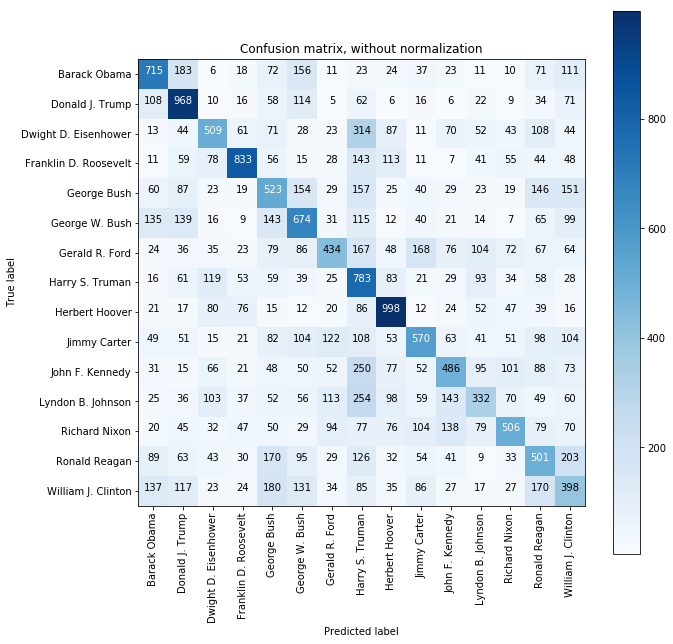

In [34]:
# from scikit-learn examples @
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix, without normalization')

# #Plot normalized confusion matrix
# plt.figure(figsize=(10,10))
# plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()